In [1]:
import os
import random
import itertools
import re
import collections

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from tqdm import tqdm
import warnings

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image, HTML
from six import StringIO
from ipywidgets import interact, FloatSlider
from dtreeviz.trees import *

import optuna

# 評価指標
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# models
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析
from lightgbm import LGBMClassifier
import xgboost as xgb


# XAI
import shap


import config
import functions

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


# 最適化

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

## Random Forest

0it [00:00, ?it/s]

##################################################
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


  0%|          | 0/1000 [00:00<?, ?it/s]

{'n_estimators': 893, 'max_depth': 12, 'max_leaf_nodes': 20, 'min_samples_split': 12, 'min_samples_leaf': 23}
0.631578947368421



0it [00:00, ?it/s]
1it [00:01,  1.04s/it]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RandomForestClassifier,1.0,0.55,1.0,0.470588


subgroup:  Her2


  0%|          | 0/1000 [00:00<?, ?it/s]

{'n_estimators': 14, 'max_depth': 17, 'max_leaf_nodes': 48, 'min_samples_split': 73, 'min_samples_leaf': 28}
0.7499999999999999



0it [00:00, ?it/s]
1it [00:00,  9.60it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RandomForestClassifier,1.0,0.545455,1.0,0.0


subgroup:  LumA


  0%|          | 0/1000 [00:00<?, ?it/s]

{'n_estimators': 781, 'max_depth': 40, 'max_leaf_nodes': 62, 'min_samples_split': 32, 'min_samples_leaf': 71}
0.7096774193548387



0it [00:00, ?it/s]
1it [00:00,  1.08it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RandomForestClassifier,1.0,0.4,1.0,0.454545


1it [20:33, 1233.83s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


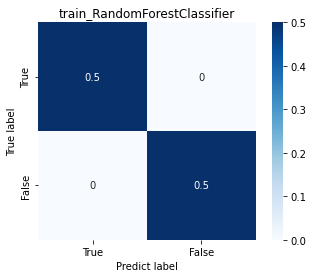

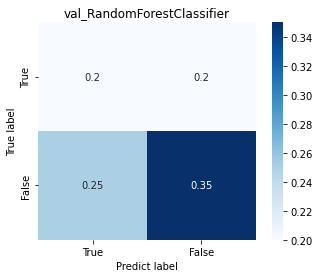

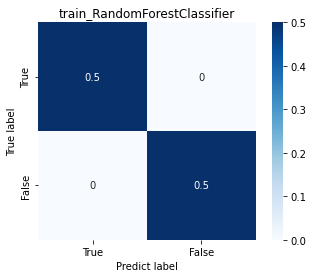

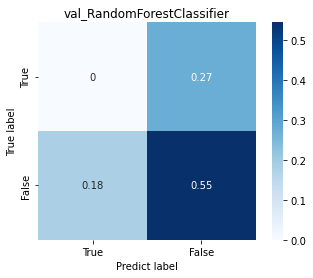

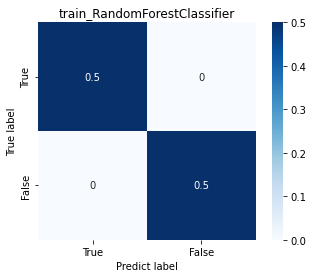

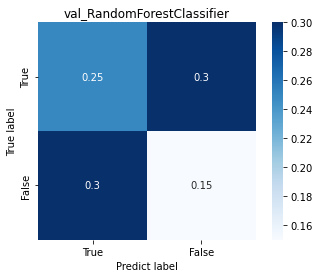

In [5]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 100),
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = RandomForestClassifier()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "n_estimators": study.best_params["n_estimators"],
                "max_depth": study.best_params["max_depth"],
                "max_leaf_nodes": study.best_params["max_leaf_nodes"],
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf],
                    plot=True,
                )
            )

### LogisticRegression

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.375



1it [00:00, 10.27it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.898148,0.5,0.898148,0.375


subgroup:  Her2


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.4



1it [00:00, 11.03it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.985075,0.727273,0.985075,0.4


subgroup:  LumA


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.380952380952381



1it [00:00, 10.04it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.885417,0.35,0.885417,0.380952


1it [00:11, 11.06s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


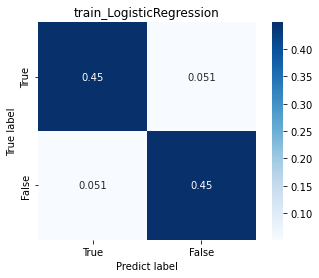

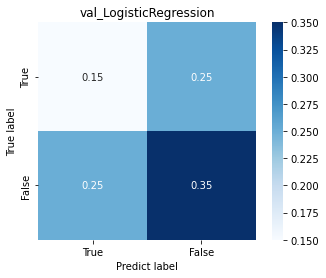

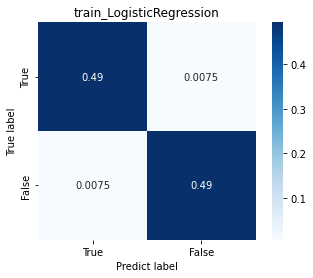

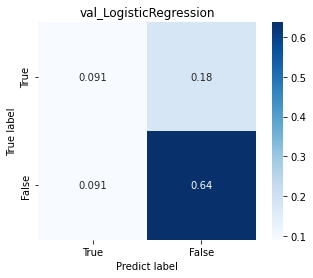

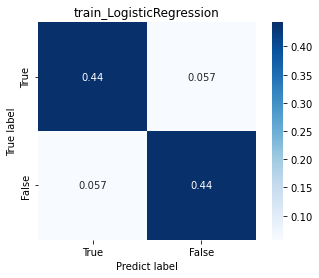

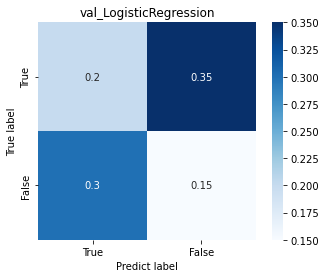

In [4]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-5, 1e5),
        "max_iter": 1000,
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = LogisticRegression(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = LogisticRegression()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "penalty": study.best_params["penalty"],
                "C": study.best_params["C"],
                "max_iter": 1000,
                "solver": "liblinear",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf],
                    plot=True,
                )
            )

## SVM(linear)

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 1.4000217200207106}
0.35294117647058826



0it [00:00, ?it/s]
1it [00:00,  5.62it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.888889,0.45,0.889908,0.352941


subgroup:  Her2


  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 543.4053983860236}
0.4



0it [00:00, ?it/s]
1it [00:00,  1.06it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.985075,0.727273,0.985075,0.4


subgroup:  LumA


  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 543.4053983860236}
0.380952380952381



0it [00:00, ?it/s]
1it [00:00,  2.22it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.90625,0.35,0.907216,0.380952


1it [14:03, 843.86s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


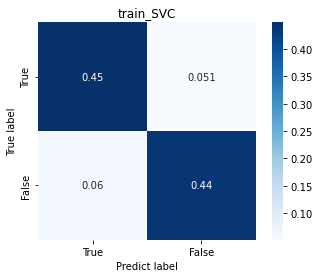

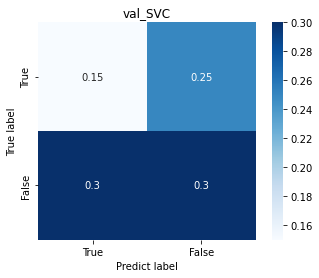

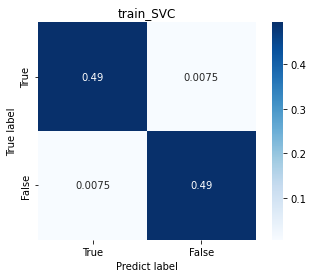

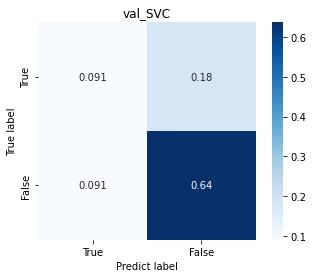

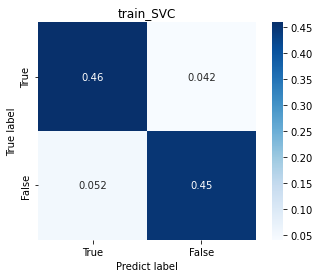

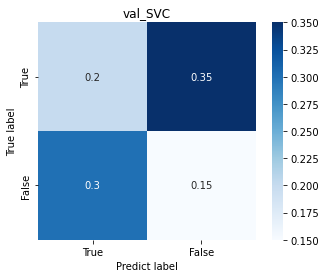

In [3]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e3),
        "kernel": "linear",
        "max_iter": -1,
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = SVC(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            # init model
            clf = SVC()

            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            functions.make_dir(input_file_path)
            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue
            X_train, y_train = list_train[0], list_train[1]
            X_val, y_val = list_val[0], list_val[1]

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "C": study.best_params["C"],
                "kernel": "linear",
                "max_iter": -1,
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf],
                    plot=True,
                )
            )